### 제주도의 태양광 발전량 예측

In [26]:
import pandas as pd

df = pd.read_csv("./data/한국전력거래소_시간별 육지 제주 태양광 및 풍력발전량_20230228.csv", encoding="cp949")
df.columns

Index(['거래일', '거래시간', ' 육지태양광 총발전량(MWh) ', ' 육지풍력 총발전량(MWh) ',
       ' 제주태양광 총발전량(MWh) ', ' 제주풍력 총발전량(MWh) ', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'],
      dtype='object')

### 데이터 살펴보기

In [27]:
df.head()                   # 22년 9월 1일부터
df.tail()                   # 23년 2월 28일까지
df["거래일"].value_counts() # 1시간 단위로 측정

2022-09-01    24
2022-12-24    24
2022-12-26    24
2022-12-27    24
2022-12-28    24
              ..
2022-11-02    24
2022-11-03    24
2022-11-04    24
2022-11-05    24
2023-02-28    24
Name: 거래일, Length: 181, dtype: int64

In [28]:
import warnings

warnings.filterwarnings("ignore")

df_sun_data = df[['거래일', ' 육지태양광 총발전량(MWh) ']]                                                           # 일자와 태양광 발전량만 사용
df_sun_data[' 육지태양광 총발전량(MWh) '] = df_sun_data[' 육지태양광 총발전량(MWh) '].apply(lambda x : round(x, 2))  # 총 발전량의 경우 소숫점 둘째자리까지 사용
df_sun_data

,거래일,육지태양광 총발전량(MWh)
0,2022-09-01,2.00
1,2022-09-01,0.46
2,2022-09-01,1.01
3,2022-09-01,0.33
4,2022-09-01,0.02
...,...,...
4339,2023-02-28,886.52
4340,2023-02-28,856.94
4341,2023-02-28,602.91
4342,2023-02-28,232.57


### 원본데이터 시각화

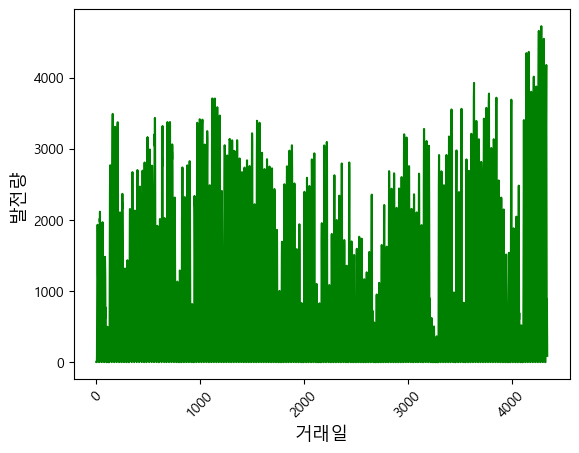

In [29]:
import matplotlib.pyplot as plt, matplotlib as mlp

mlp.rcParams["font.family"] = "Malgun Gothic"

plt.plot(df_sun_data[" 육지태양광 총발전량(MWh) "], color="green")
plt.xlabel("거래일")
plt.ylabel("발전량")
plt.xticks(rotation = 45)
plt.show()

### 데이터셋 구성 함수 정의

In [30]:
import numpy as np

def create_dataset(dataset, maxlen):         # maxlen은 다음 시간 영역 예측을 위한 앞쪽 시간대의 스텝 수
    dataX, dataY = [], []                    # maxlen이 3이라고 가정하면, x는 t-2, t-1, t시점의 발전량이며, y는 t+1시점의 발전량으로 구성된다.
    for i in range(len(dataset)-maxlen-1):   
        a = dataset[i:(i+maxlen), 0]         # t-2, t-1, t시점의 발전량 추출
        dataX.append(a)                      # X데이터로 구성
        dataY.append(dataset[i + maxlen, 0]) # t+1 시점의 발전량 추출, Y데이터로 구성
    return np.array(dataX), np.array(dataY)  

### 데이터셋 구성

In [31]:
from sklearn.preprocessing import MinMaxScaler

dataset = df_sun_data[[" 육지태양광 총발전량(MWh) "]].values # ndarray 타입으로 변환
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1)) # 정규화 객체 생성
dataset = scaler.fit_transform(dataset)     # 정규화 진행

# train, test를 7:3 비율로 분할
train_size = int(len(dataset) * 0.7)         
test_size = len(dataset) - train_size      
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

maxlen = 24                                     # 24시간 단위
trainX, trainY = create_dataset(train, maxlen)  # 훈련셋 구성
testX, testY = create_dataset(test, maxlen)     # 테스트셋 구성
 
print(trainX.shape, trainY.shape)

# lstm model에 맞게 형상 변환
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # 모든 데이터의 개수, 일수(하루 단위), 스텝 수(24시간 단위 데이터)로 학습 데이터를 구성
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 형상 변환 후의 크기 확인
print(trainX.shape, testX.shape)

(3015, 24) (3015,)
(3015, 1, 24) (1279, 1, 24)


### Callbacks 정의

In [32]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# callback 함수 정의
mch = ModelCheckpoint("./lstm_sun/lstm_sun_{epoch:02d}-{loss:.4f}.hdf5", monitor="loss", save_best_only=True, verbose=1, )
els = EarlyStopping(monitor = "loss", mode = "min", patience=3, verbose = 1)
loss_lr = ReduceLROnPlateau(monitor="loss", mode="min", patience=5, factor=0.03)

### 모델 설계 및 학습

In [33]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

input_layer = Input(shape=(1, maxlen)) # (특성의 개수, time steps)
x = LSTM(64)(input_layer)
output_layer = Dense(1)(x)
model = Model(input_layer, output_layer)
model.compile(optimizer = "adam", loss = "mean_squared_error")

# 학습
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, callbacks=[mch, els, loss_lr])

Epoch 1/100
3014/3015 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 1: loss improved from inf to 0.00510, saving model to ./lstm_sun\lstm_sun_01-0.0051.hdf5
3015/3015 [==============================] - 8s 2ms/step - loss: 0.0051 - lr: 0.0010
Epoch 2/100
3010/3015 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 2: loss improved from 0.00510 to 0.00236, saving model to ./lstm_sun\lstm_sun_02-0.0024.hdf5
3015/3015 [==============================] - 7s 2ms/step - loss: 0.0024 - lr: 0.0010
Epoch 3/100
3013/3015 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 3: loss improved from 0.00236 to 0.00193, saving model to ./lstm_sun\lstm_sun_03-0.0019.hdf5
3015/3015 [==============================] - 7s 2ms/step - loss: 0.0019 - lr: 0.0010
Epoch 4/100
2997/3015 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 4: loss improved from 0.00193 to 0.00163, saving model to ./lstm_sun\lstm_sun_04-0.0016.hdf5
3015/3015 [======================

### 성능 평가, 예측 결과 산출

In [34]:
import math
from sklearn.metrics import mean_squared_error

model.load_weights("./lstm_sun/lstm_sun_47-0.0004.hdf5") # 이미 학습된 가중치 적용

trainPredict = model.predict(trainX) # 학습 데이터에 대한 예측
testPredict = model.predict(testX)   # 테스트 데이터에 대한 예측

# 예측된 결과를 원래의 형태로 반환(정규화했던 형태에서 비정규화 형태로 다시 변환)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# RMSE 지표 측정
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

40/40 [==============================] - 0s 1ms/step
Train Score: 99.20 RMSE
Test Score: 155.20 RMSE


### 예측 결과 가시화

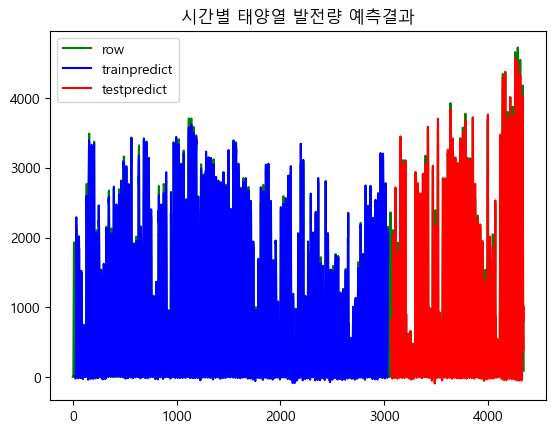

In [37]:
trainPredictPlot = np.empty_like(dataset)                           # 시각화를 위해 dataset의 길이만큼 배열 생성
trainPredictPlot[:, :] = np.nan                                     # nan값으로 초기화를 진행하고
trainPredictPlot[maxlen:len(trainPredict)+maxlen, :] = trainPredict # 스텝(24)까지는 nan값으로 유지하고, 나머지는 예측된 결과로 채운다.

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(maxlen*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), color ="g", label = "row") # 원본 데이터를 초록색으로 시각화
plt.plot(trainPredictPlot,color="b", label="trainpredict")             # 훈련 데이터 예측 결과를 파란색으로 시각화
plt.plot(testPredictPlot,color="r", label="testpredict")               # 테스트 데이터 예측 결과를 빨간색으로 시각화
plt.title('시간별 태양열 발전량 예측결과') 
plt.legend()
plt.show()

### 임의의 날짜에 대해 예측하기

1/1 [==============================] - 0s 17ms/step


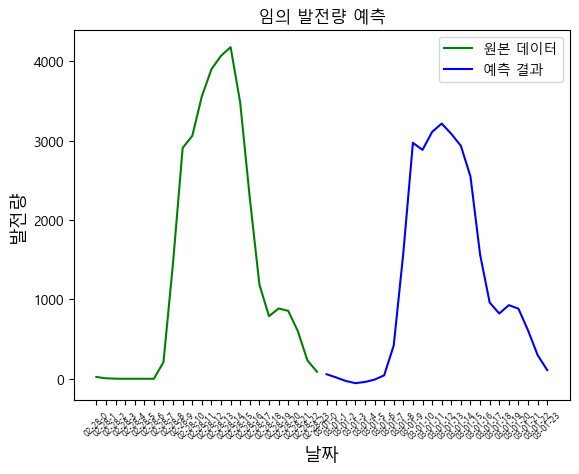

In [41]:
last_seq = dataset[-maxlen:]  # 2023년 2월 28일의 24시간 데이터를 가지고
future_seq = []
for i in range(0, 24):        # 예측할 시간 범위 설정 (3월 1일 24시간 데이터를 예측)
    input_seq = np.array(last_seq[-maxlen:]).reshape(1, 1, maxlen)
    future_result = model.predict(input_seq) # 28일 하루의 데이터로 예측한 결과 = 다음날의 1시간 예측 결과
    future_seq.append(future_result)         # 리스트에 별도로 저장하고
    last_seq = np.concatenate((last_seq, future_result), axis=0) # 28일 데이터와 합친다. 합쳐지고 나면 28일 새벽 1시 ~ 3월1일 00시의 데이터로 다시 3월 1일의 새벽 1시 데이터 예측

# 예측 결과를 원래 스케일로 복원
future_seq = scaler.inverse_transform(np.array(future_seq).reshape(-1, 1))

# 3월 1일부터 
future_dates = [f"03-01-{i}" for i in range(0, 24)]

# x축에 사용할 2월 28일의 24시간 라벨
past_dates = [f"02-28-{i}" for i in range(0, 24)]

# 시각화
plt.plot(past_dates, scaler.inverse_transform(dataset)[-24:], color='g', label='원본 데이터')  # 원본 데이터의 가시화
plt.plot(future_dates, future_seq, color='b', label='예측 결과')  # 미지의 날짜 예측 결과 가시화
plt.xlabel('날짜')
plt.xticks(rotation = 45, size = 6)
plt.ylabel('발전량')
plt.title('임의 발전량 예측')
plt.legend()
plt.show()